[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Zaba_et_al_2025/isotope_ventilation_coefficient_ratio.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Zaba_et_al_2025/isotope_ventilation_coefficient_ratio.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Zaba_et_al_2025/isotope_ventilation_coefficient_ratio.ipynb)

## Based on [Brutsaert 1982]() statement on Schmidt number vs. isotopes


In [8]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [9]:
import numpy as np
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si, in_unit
from matplotlib import pyplot

In [10]:
formulae = Formulae(
    terminal_velocity="RogersYau",
    isotope_diffusivity_ratios="HellmannAndHarvey2020",
    ventilation="PruppacherAndRasmussen1979",
    particle_shape_and_density="LiquidSpheres",
    air_dynamic_viscosity="ZografosEtAl1987",
)

In [11]:
def f_iso_to_f(f, temperature):
    D_heavy_to_light = formulae.isotope_diffusivity_ratios.ratio_18O(temperature)
    return (1 + (f-1)*(D_heavy_to_light)**(1/3)) / f

In [12]:
def f(formulae, radius, temperature):
    eta_air = formulae.air_dynamic_viscosity.eta_air(temperature)
    air_density = formulae.constants.p_STP / formulae.constants.Rd / temperature
    X = formulae.trivia.sqrt_re_times_cbrt_sc(
            Re = formulae.particle_shape_and_density.reynolds_number(
                radius = radius, 
                velocity_wrt_air=formulae.terminal_velocity.v_term(radius), 
                dynamic_viscosity = eta_air, 
                density = air_density
            ), 
            Sc = formulae.trivia.air_schmidt_number(
                dynamic_viscosity=eta_air,
                diffusivity=formulae.diffusion_thermics.D(T=temperature, p=formulae.constants.p_STP),
                density=air_density,
            )
        )
    return X, formulae.ventilation.ventilation_coefficient(X)

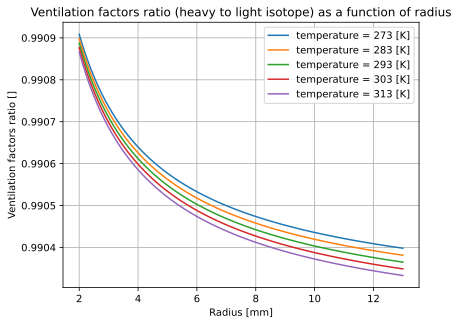

In [13]:
temperature = np.linspace(273.15, 313.15, 5) *si.K
radius = np.linspace(2, 13, 100) * si.mm
fig, ax = pyplot.subplots(1)

for t in temperature:
    _, f_coeff = f(formulae, radius, t)
    f_ratio = f_iso_to_f(f_coeff,t)
    ax.plot(in_unit(radius, si.mm), f_ratio, label=f"temperature = {t:.3g} [K]")
ax.set_title("Ventilation factors ratio (heavy to light isotope) as a function of radius")
ax.set_xlabel("Radius [mm]")
ax.set_ylabel("Ventilation factors ratio []")
ax.grid()
ax.legend()
show_plot("f_ratio_of_radii.pdf")